At the end of this step, you will understand the concepts of underfitting and overfitting, and you will be able to apply these ideas to make your models more accurate.

# Experimenting With Different Models

Now that you have a reliable way to measure model accuracy, you can experiment with alternative models and see which gives the best predictions.  But what alternatives do you have for models?

You can see in scikit-learn's [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) that the decision tree model has many options (more than you'll want or need for a long time). The most important options determine the tree's depth.  Recall from [the first lesson in this micro-course](https://www.kaggle.com/dansbecker/how-models-work) that a tree's depth is a measure of how many splits it makes before coming to a prediction.  This is a relatively shallow tree

![Depth 2 Tree](http://i.imgur.com/R3ywQsR.png)

In practice, it's not uncommon for a tree to have 10 splits between the top level (all houses) and a leaf.  As the tree gets deeper, the dataset gets sliced up into leaves with fewer houses.  If a tree only had 1 split, it divides the data into 2 groups. If each group is split again, we would get 4 groups of houses.  Splitting each of those again would create 8 groups.  If we keep doubling the number of groups by adding more splits at each level, we'll have \\(2^{10}\\) groups of houses by the time we get to the 10th level. That's 1024 leaves.  

When we divide the houses amongst many leaves, we also have fewer houses in each leaf.  Leaves with very few houses will make predictions that are quite close to those homes' actual values, but they may make very unreliable predictions for new data (because each prediction is based on only a few houses).

This is a phenomenon called **overfitting**, where a model matches the training data almost perfectly, but does poorly in validation and other new data.  On the flip side, if we make our tree very shallow, it doesn't divide up the houses into very distinct groups.  

At an extreme, if a tree divides houses into only 2 or 4, each group still has a wide variety of houses. Resulting predictions may be far off for most houses, even in the training data (and it will be bad in validation too for the same reason). When a model fails to capture important distinctions and patterns in the data, so it performs poorly even in training data, that is called **underfitting**.  

Since we care about accuracy on new data, which we estimate from our validation data, we want to find the sweet spot between underfitting and overfitting.  Visually, we want the low point of the (red) validation curve in

![underfitting_overfitting](http://i.imgur.com/2q85n9s.png)

# Example
There are a few alternatives for controlling the tree depth, and many allow for some routes through the tree to have greater depth than other routes.  But the *max_leaf_nodes* argument provides a very sensible way to control overfitting vs underfitting.  The more leaves we allow the model to make, the more we move from the underfitting area in the above graph to the overfitting area.

We can use a utility function to help compare MAE scores from different values for *max_leaf_nodes*:


In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

The data is loaded into **train_X**, **val_X**, **train_y** and **val_y** using the code you've already seen (and which you've already written).

In [2]:
# Data Loading Code Runs At This Point
import pandas as pd
    
# Load data
melbourne_file_path = './data/melb_data.csv'
melbourne_data = pd.read_csv(melbourne_file_path) 
# Filter rows with missing values
filtered_melbourne_data = melbourne_data.dropna(axis=0)

# Choose target and features
y = filtered_melbourne_data.Price
melbourne_features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 
                        'YearBuilt', 'Lattitude', 'Longtitude']
X = filtered_melbourne_data[melbourne_features]

from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [4]:
filtered_melbourne_data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,6196.000000,6.196000e+03,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000
mean,2.931407,1.068828e+06,9.751097,3101.947708,2.902034,1.576340,1.573596,471.006940,141.568645,1964.081988,-37.807904,144.990201,7435.489509
std,0.971079,6.751564e+05,5.612065,86.421604,0.970055,0.711362,0.929947,897.449881,90.834824,38.105673,0.075850,0.099165,4337.698917
min,1.000000,1.310000e+05,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000,-38.164920,144.542370,389.000000
25%,2.000000,6.200000e+05,5.900000,3044.000000,2.000000,1.000000,1.000000,152.000000,91.000000,1940.000000,-37.855438,144.926198,4383.750000
50%,3.000000,8.800000e+05,9.000000,3081.000000,3.000000,1.000000,1.000000,373.000000,124.000000,1970.000000,-37.802250,144.995800,6567.000000
75%,4.000000,1.325000e+06,12.400000,3147.000000,3.000000,2.000000,2.000000,628.000000,170.000000,2000.000000,-37.758200,145.052700,10175.000000
max,8.000000,9.000000e+06,47.400000,3977.000000,9.000000,8.000000,10.000000,37000.000000,3112.000000,2018.000000,-37.457090,145.526350,21650.000000


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_corr(corr):
    """
    绘制相关系数矩阵热度图
    Corr：相关系数矩阵
    """
    plt.figure(figsize=(17, 17))
    c_map = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=c_map, square=True, center=0.0)
    plt.show()

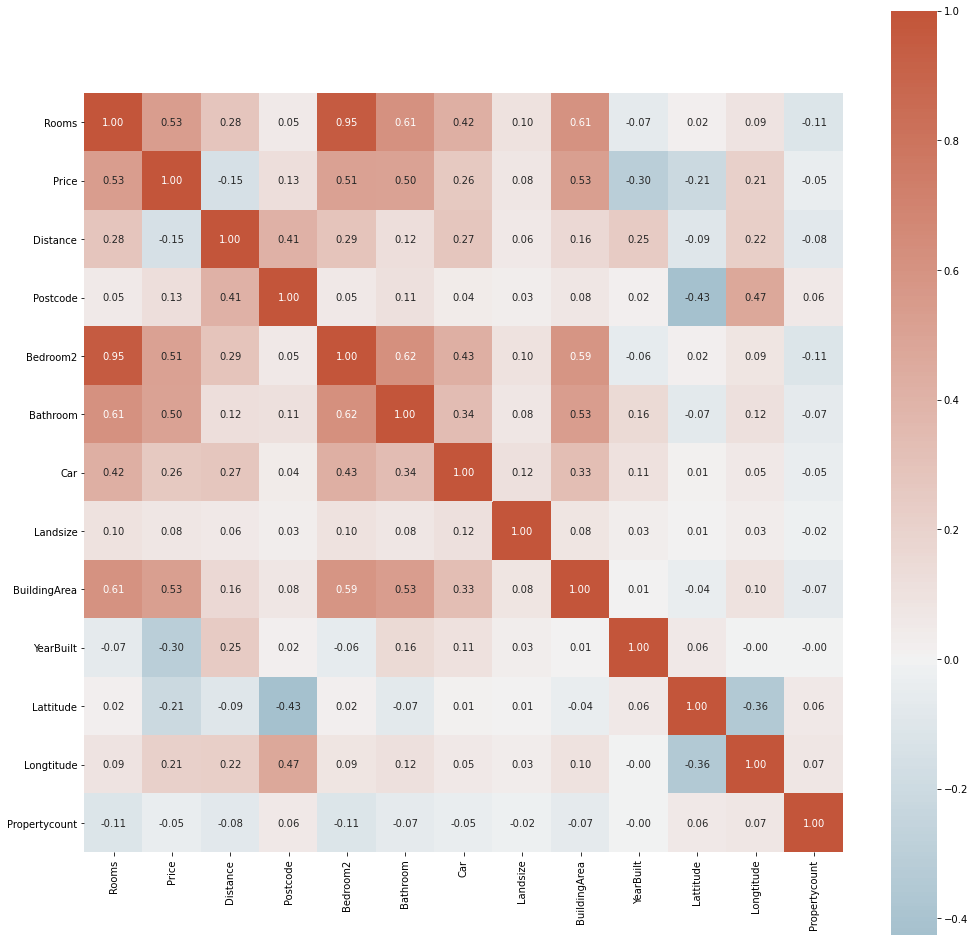

In [6]:
df = filtered_melbourne_data.copy()

col_list = df.columns.tolist()
corr_ = df.corr()
plot_corr(corr_)

In [ ]:
import numpy as np
import math

import plotly.graph_objects as go
import networkx as nx
from ipywidgets import Layout, widgets


threshold_choice = widgets.FloatSlider(description="Threshold", value=0.8, min=0.5, max=1, step=0.05, continuous_update=False, orientation='horizontal',
                           layout=Layout(width='500px'), style=dict(description_width= 'initial'))

network = go.FigureWidget(data=[go.Scatter(x=[], y=[], mode='lines', text=[],  line=dict(color='MediumPurple',width=10),
                                           marker=dict(size=20, line_width=10,line=dict(color='MediumPurple',width=2))),
                                go.Scatter(x=[], y=[],mode='markers+text', textposition="top center", 
                                          text=[],hoverinfo='text',textfont_size=12, marker=dict(size=50, color=[],line_width=1))],
                          layout=go.Layout( showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0), width=1600, height=800))

correlation_matrix = corr_.to_numpy()

def plot_corr_graph(change):
    threshold, corr_mode = None, None

    threshold = change.new
    
    tr_ind = np.triu_indices(correlation_matrix.shape[0])
    correlation_matrix[tr_ind] = 0

    G = nx.from_numpy_matrix(correlation_matrix)
    G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
    # 49 x 49 - 49 (self corr) / 2 (remove upper triang)

    remove = []
    
    for col1, col2, weight in G.edges(data=True):

        if math.isnan(weight["weight"]):
            remove.append((col1,col2))
    
        if abs(weight["weight"]) < threshold:
            remove.append((col1,col2))
    
    G.remove_edges_from(remove)
    
    remove = []
    edges = list(sum(G.edges, ()))

    for node in G.nodes:
        if node not in edges:
            remove.append(node)

    G.remove_nodes_from(remove)
    mst = nx.maximum_spanning_tree(G)

    def assign_color(col):
      return sector_color_mapping[sp500_sector_mapping[col]]

    # def assign_thickness(correlation, benchmark_thickness=20, scaling_factor=2):
    #   return benchmark_thickness * abs(correlation)**scaling_factor

    # def assign_node_size(degree, scaling_factor=500):
    #   return degree * scaling_factor

    def assign_color_edge(correlation):
      if correlation < 0:
        return "#BF0603"
      else:
        return "#00CC66"

    edge_colors = []
    # edge_width = []
    # node_size = []
    node_colors = []

    for key, value in nx.get_edge_attributes(mst, 'weight').items():
        edge_colors.append(assign_color_edge(value))
        # edge_width.append(assign_thickness(value))

    for key, value in dict(mst.degree).items():
        # node_size.append(assign_node_size(value))
        node_colors.append(assign_color(key))
      
    labels = {n:n for n in mst.nodes()}
    node_x = []
    node_y = []
    
    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()
    
    for node, (x_,y_) in tree:
        node_x.append(x_)
        node_y.append(y_)
        
    def get_dim_of_node(name):
        for node, (x,y) in tree:
            if node == name:
                return x,y
        
    edge_x = []
    edge_y = []
    
    weights= []
    for node1, node2, w in mst.edges(data=True):
        x0, y0 = get_dim_of_node(node1)
        x1, y1 =  get_dim_of_node(node2)
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append((round(w["weight"],1), (x0+x1)/2, (y0+y1)/2))
    # annotations_list =[dict(x=weight[1], y=weight[2], xref='x', yref='y', text=weight[0], ax=weight[1], ay=weight[2]) for weight in weights]
                              
    with network.batch_update():
        network.data[1].x = node_x
        network.data[1].y = node_y
        network.data[1].text = list(labels)
        network.data[1].marker.color = node_colors
        # network.update_layout(annotations=annotations_list)
                          
        network.data[0].x = edge_x
        network.data[0].y = edge_y
        network.data[0].text = list(weights)
        network.update_layout(xaxis_zeroline=False, yaxis_zeroline=False, xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor='rgba(0,0,0,0)')

threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice])

We can use a for-loop to compare the accuracy of models built with different values for *max_leaf_nodes.*

In [3]:
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  347380
Max leaf nodes: 50  		 Mean Absolute Error:  258171
Max leaf nodes: 500  		 Mean Absolute Error:  243495
Max leaf nodes: 5000  		 Mean Absolute Error:  254983



Of the options listed, 500 is the optimal number of leaves.

---

# Conclusion

Here's the takeaway: Models can suffer from either:
- **Overfitting:** capturing spurious patterns that won't recur in the future, leading to less accurate predictions, or 
- **Underfitting:** failing to capture relevant patterns, again leading to less accurate predictions. 

We use **validation** data, which isn't used in model training, to measure a candidate model's accuracy. This lets us try many candidate models and keep the best one. 



# Your Turn

Try **[optimizing the model you've previously built](https://www.kaggle.com/kernels/fork/2247665)**.